In [1]:
import pandas as pd
from darts import TimeSeries

In [2]:

df = pd.read_csv('../../data/airline-passengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', 'Passengers')
train, val = series.split_after(pd.Timestamp('19580101'))


In [3]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))


Importing plotly failed. Interactive plots will not work.
/anaconda/envs/darts/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Text(0.5, 0, 'Year')

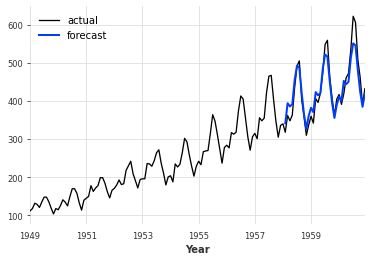

In [4]:
import matplotlib.pyplot as plt

series.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Year')


In [7]:
val

            Passengers
Month                 
1958-02-01         318
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491
1958-08-01         505
1958-09-01         404
1958-10-01         359
1958-11-01         310
1958-12-01         337
1959-01-01         360
1959-02-01         342
1959-03-01         406
1959-04-01         396
1959-05-01         420
1959-06-01         472
1959-07-01         548
1959-08-01         559
1959-09-01         463
1959-10-01         407
1959-11-01         362
1959-12-01         405
1960-01-01         417
1960-02-01         391
1960-03-01         419
1960-04-01         461
1960-05-01         472
1960-06-01         535
1960-07-01         622
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432
Freq: MS